#### 5 year Forecasting With Online Sales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [4]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [8]:
online_channel= df.loc[df['Region'] == 'France',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
1,2011-05-31,Online,3399.99,France
41,2011-06-10,Online,3578.27,France
53,2011-06-13,Online,3578.27,France
54,2011-06-13,Online,3578.27,France
83,2011-06-20,Online,3578.27,France
...,...,...,...,...
60165,2014-06-27,Online,2.29,France
60166,2014-06-27,Online,28.99,France
60167,2014-06-27,Online,4.99,France
60168,2014-06-27,Online,2.29,France


### Data Preprocessing

In [9]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [10]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,3399.99
1,2011-06-10,3578.27
2,2011-06-13,7156.54
3,2011-06-20,3578.27
4,2011-06-21,7156.54
...,...,...
713,2014-06-24,125.93
714,2014-06-25,21.98
715,2014-06-26,155.56
716,2014-06-27,430.89


### Indexing with Time Series Data

In [11]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-06-10', '2011-06-13', '2011-06-20',
               '2011-06-21', '2011-06-22', '2011-06-23', '2011-06-25',
               '2011-06-26', '2011-06-29',
               ...
               '2014-06-19', '2014-06-20', '2014-06-21', '2014-06-22',
               '2014-06-23', '2014-06-24', '2014-06-25', '2014-06-26',
               '2014-06-27', '2014-06-28'],
              dtype='datetime64[ns]', name='OrderDate', length=718, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [12]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [10]:
y['2014':]

OrderDate
2014-01-01    3034.970323
2014-02-01    2767.759286
2014-03-01    3510.029032
2014-04-01    4539.277000
2014-05-01    4293.961290
2014-06-01     346.051667
Freq: MS, Name: Total_Sales, dtype: float64

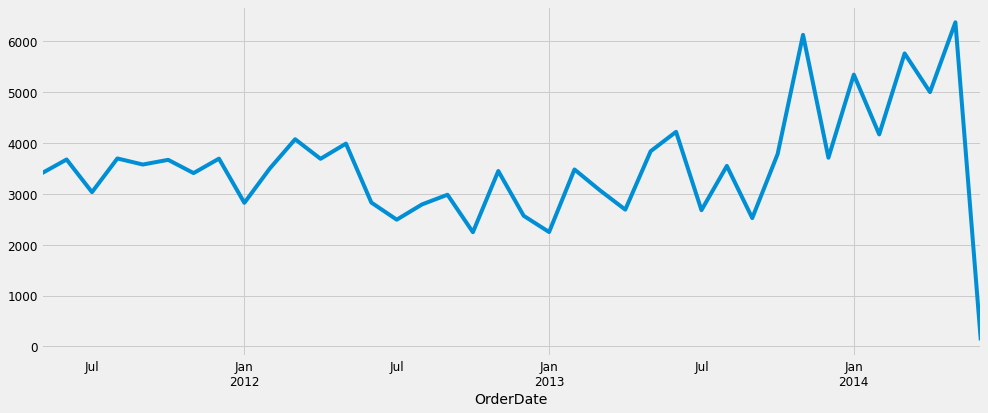

In [13]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

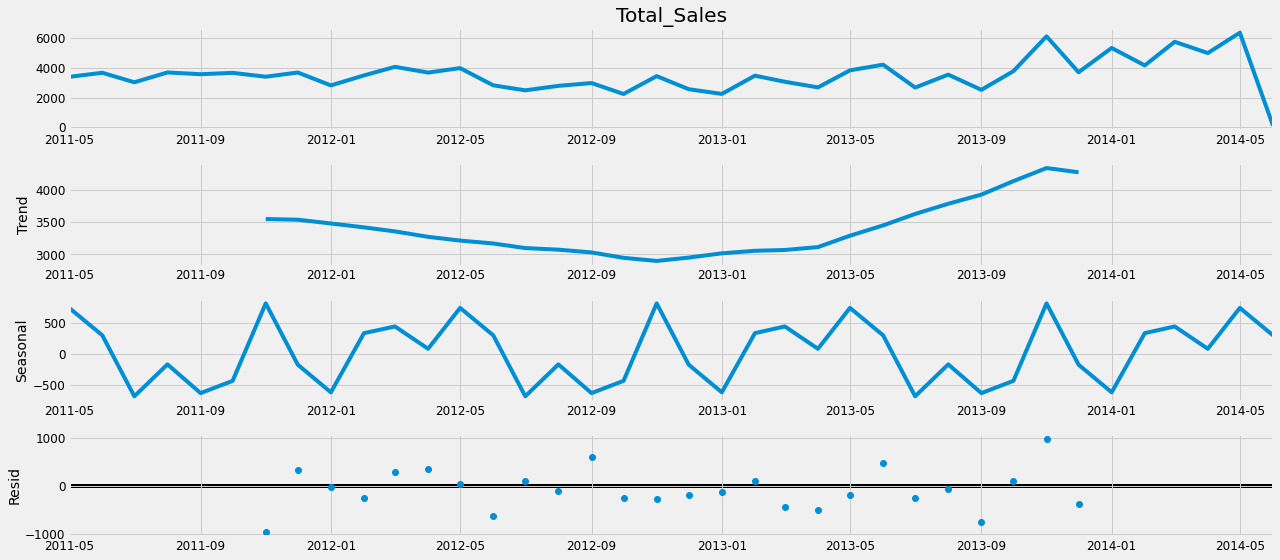

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [16]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:715.3929448586244
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1241.482762940413
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:443.12030870783116
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:239.4372601638354
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:461.75650536160435
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:438.49949978568435
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:246.54703638039203
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:231.07124791980553
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:669.751848129197
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2059.675062154563
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:426.46713767455896
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:223.17535669312255
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:461.92045753365
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:423.90756735417074
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:248.50120088350764
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:216.40340295688347
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:628.3795489964272
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1146.363641652793
ARI

 ### Fitting an ARIMA Time Series Model

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7253      0.783     -0.926      0.354      -2.260       0.809
ma.L1         -0.3484      0.585     -0.595      0.552      -1.495       0.799
ar.S.L12      -1.7996      0.604     -2.979      0.003      -2.984      -0.616
ma.S.L12       1.5081      0.494      3.053      0.002       0.540       2.476
sigma2      8.457e+05   5.34e-07   1.58e+12      0.000    8.46e+05    8.46e+05


### Validating forecasts

In [18]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


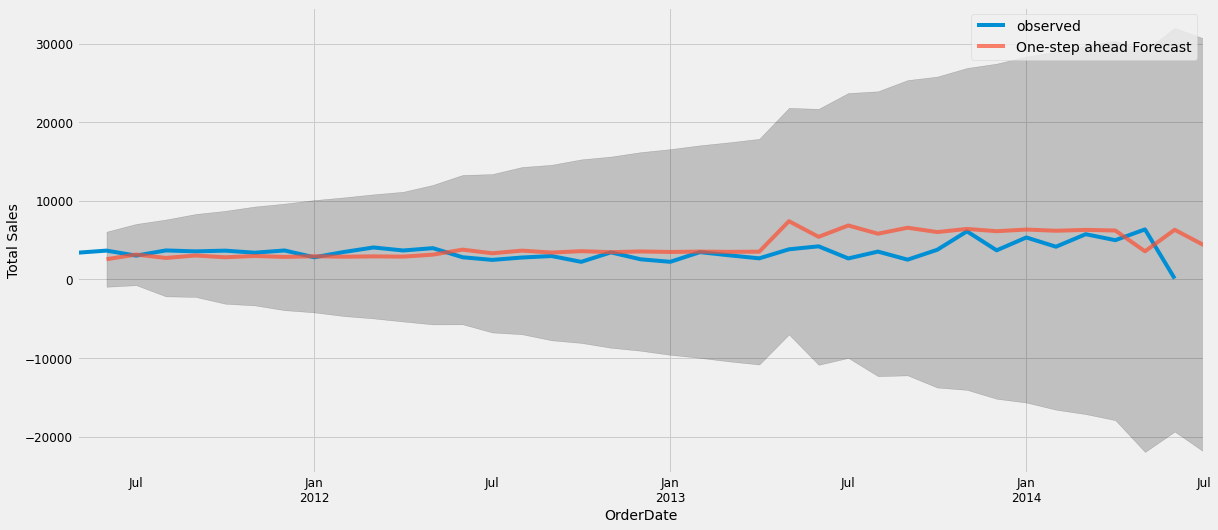

In [19]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 38555639.63


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6209.32


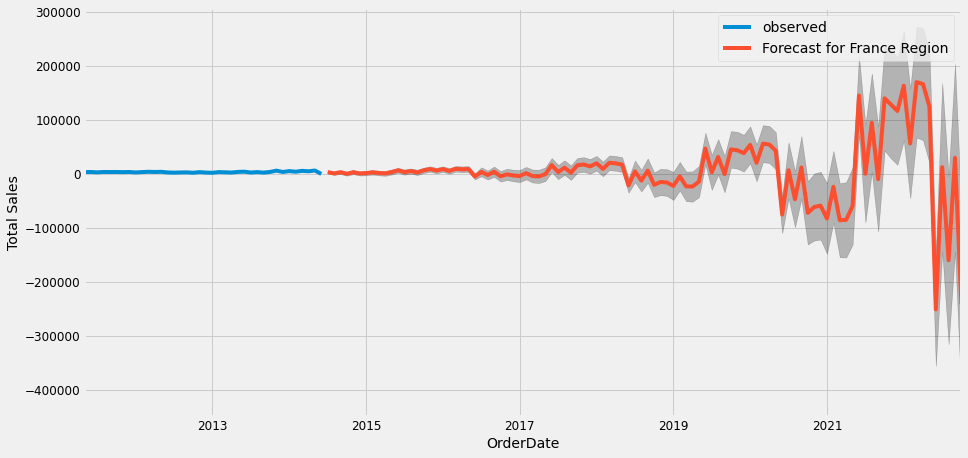

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for France Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()